In [ ]:
using Statistics
using Random
using CairoMakie
using StatsBase # probabilityweights

In [ ]:
function run_game(rng::AbstractRNG, arr::Vector, p_bw::Float64, p_none::Float64, p_fw::Float64, reversed::Bool)
    
    count = 0
    # sólo nos importa donde haya bolas, np.where(arr)
    # de derecha a izquierda queda np.where(arr)[0][:-1]  
    if reversed
        # conseguimos índices donde hay bolas
        idx = reverse(findall(x -> x==1, arr))
    else
        idx = findall(x -> x==1, arr)
    end
    
    for ii in idx
        # che arreglo feo pero ps Julia quería iniciar en [1]
        id_fw = mod( ii, length(arr) ) + 1
        id_bw = mod( (ii - 1 - 1), length(arr) ) + 1
        
        if (arr[id_fw] == 0 && arr[id_bw] == 0)
            # ahuevo se mueve
            direction = sample(rng, [-1,0,+1], ProbabilityWeights([p_bw, p_none, p_fw]))
            arr[ii] = 0
            
            arr[mod(ii + direction,length(arr)) + 1] = 1

            count += direction
        # se puede mover sólo hacia adelante
        elseif arr[id_fw] == 0
            # escogemos entre 0 y 1 para decidir si se mueve o se queda
            direction = sample(rng, [0,0, +1], ProbabilityWeights([p_bw,p_none, p_fw]))
            arr[ii] = 0
            arr[mod(ii + direction, length(arr)) + 1] = 1
            count += direction
        # se puede mover sólo hacia atrás
        elseif arr[id_bw] == 0
            direction = sample(rng, [-1,0,0], ProbabilityWeights([p_bw, p_none, p_fw]))
            arr[ii] = 0
            arr[mod(ii + direction,length(arr)) + 1] = 1
            count += direction
        end
    end
    return arr, count
end;

In [ ]:
function main(prob_forwards::Float64, prob_cent::Float64, prob_backwards::Float64, N::Int)
    RNG = MersenneTwister(200);

    #prob_backwards = 1 - prob_forwards
    

    #número de unos que queremos
    K = 1:N

    counts_l = zeros(N)
    counts_r = similar(counts_l)
    rho =  K / N
    
    for ii in 1:length(K)
        # crear arreglo aleatorio con 1 y 0
        array = vcat(zeros(N-ii),ones(ii))
        #println(array)
        shuffle!(RNG, array)
        # si se lee normal (normalizadas)
        counts_l[ii] = run_game(RNG, array, prob_backwards, prob_cent, prob_forwards, false)[2] / N;
        # de derecha a izquierda (normalizadas)
        # no sé por qué no sirve pero ya alv
        counts_r[ii] = run_game(RNG, array, prob_backwards, prob_cent, prob_forwards, true)[2] / N;
    end
    return rho, counts_l, counts_r
end;

# multiple dispatch
main(prob_forwards::Float64, N::Float64) = main(prob_forwards, ceil(Int, N));
main(prob_forwards::Int, N::Float64) = main(convert(Float64, prob_forwards), ceil(Int, N));
main(prob_forwards::Int, N::Int) = main(convert(Float64, prob_forwards), N);

In [ ]:
@time begin
    rho, counts_l, counts_r = main(.5,0., 1.0, 1_000);
end;

  0.154318 seconds (2.05 M allocations: 159.398 MiB, 20.82% gc time)


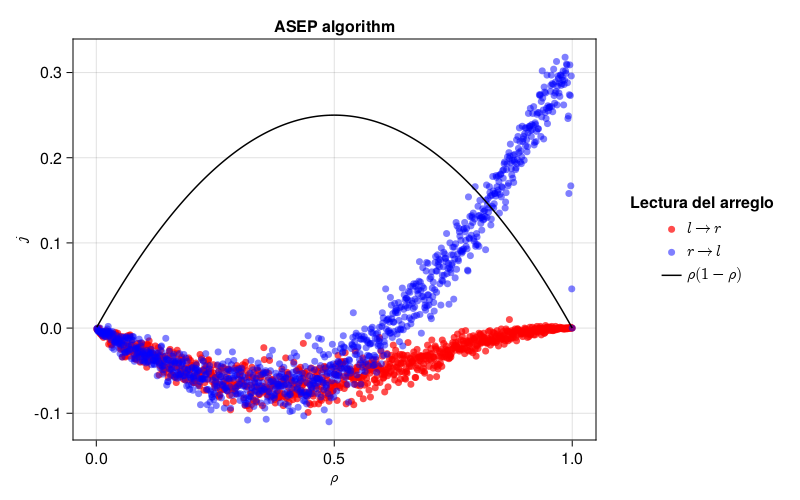

In [ ]:
f = Figure(resolution = (800, 500))

ax1 = Axis(f[1,1], title="ASEP algorithm", xlabel=L"\rho", ylabel=L"j")
    
scatter!(ax1, rho, counts_l, 
        label=L"l\rightarrow r", 
        color=(:red, 0.7), 
        colormap=:thermal,
        markersize=7.)
scatter!(ax1, rho, counts_r, 
        label=L"r\rightarrow l", 
        color=(:blue, 0.5), 
        colormap=:thermal, 
        markersize=7.)

lines!(ax1, rho, rho .* (1 .- rho), color=:black,label=L"\rho(1 - \rho)")
f[1, 2] = Legend(f, ax1, "Lectura del arreglo", framevisible = false)
f